In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

In [3]:
df = pd.read_csv('EDA1.csv')

In [4]:
well_2 = df[df['Well Name'] == 2]
well_2 = well_2[well_2['Oil Volume'] != 0]

In [5]:
well_2.reset_index(inplace = True, drop = True)

In [6]:
well_2.drop(columns = ['Day', 'Well Name'], inplace = True)

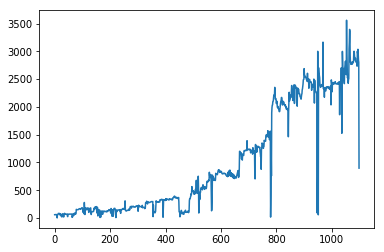

In [7]:
plt.plot(well_2['Oil Volume'])

In [8]:
values = well_2['Oil Volume'].values
values = values.reshape((len(values), 1))

In [9]:
from sklearn.preprocessing import StandardScaler

In [10]:
scaler = StandardScaler()
scaler = scaler.fit(values)

In [11]:
normalized = scaler.transform(values)

In [12]:
normalized

array([[-0.97800521],
       [-0.97800521],
       [-0.9769576 ],
       ...,
       [ 1.93436133],
       [ 1.89664723],
       [-0.1001048 ]])

In [13]:
Ndf = pd.DataFrame(data = normalized, columns = ['Oil'])

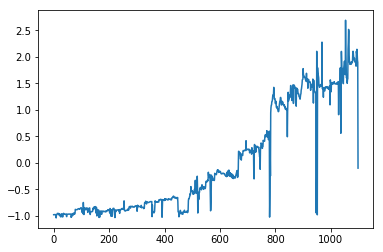

In [14]:
plt.plot(Ndf)

In [15]:
log_df = well_2['Oil Volume'].apply(lambda x: np.log(x))

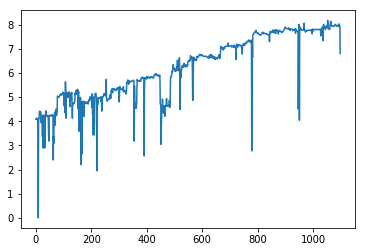

In [16]:
plt.plot(log_df)

In [17]:
Lag1 = pd.concat([well_2.shift(1), well_2], axis=1)

In [18]:
Lag1.columns = ['t-1', 't']

In [19]:
Lag1.drop(0, inplace = True)

In [20]:
X = Lag1.values

In [21]:
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

In [22]:
def model_persistence(x):
    return x

In [23]:
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)


In [24]:
from sklearn.metrics import mean_squared_error
RMSE = np.sqrt(mean_squared_error(test_y, predictions))
RMSE

320.7095492392798

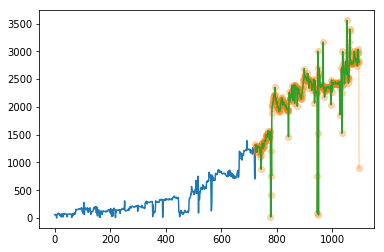

In [25]:
plt.plot(train_y)
plt.plot([None for i in train_y] + [x for x in test_y], marker = 'o', alpha = .3)
plt.plot([None for i in train_y] + [x for x in predictions])

In [26]:
from pandas.tools.plotting import autocorrelation_plot

C:\Users\csmid\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  """Entry point for launching an IPython kernel.


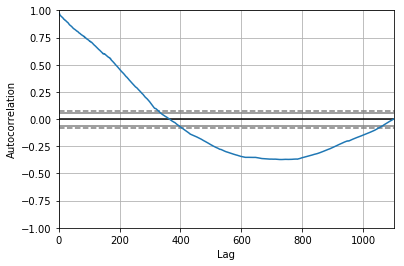

In [27]:
autocorrelation_plot(well_2)

In [28]:
from statsmodels.tsa.arima_model import ARIMA

In [29]:
model = ARIMA(well_2, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:           D.Oil Volume   No. Observations:                 1098
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -7172.869
Method:                       css-mle   S.D. of innovations            166.240
Date:                Sun, 31 Mar 2019   AIC                          14359.738
Time:                        10:39:39   BIC                          14394.747
Sample:                             1   HQIC                         14372.983
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.7070      2.374      0.719      0.472      -2.947       6.361
ar.L1.D.Oil Volume    -0.3637      0.032    -11.259      0.000      -0.427      -0.300
ar.L2.D.Oil Volume  

                 0
count  1098.000000
mean     -0.002131
std     166.315895
min   -2163.575032
25%     -18.876004
50%      -2.330268
75%      19.298918
max    1424.296175


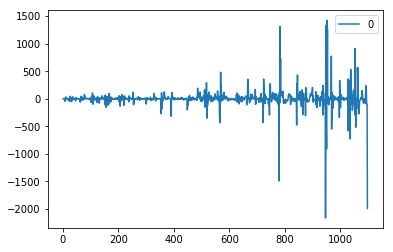

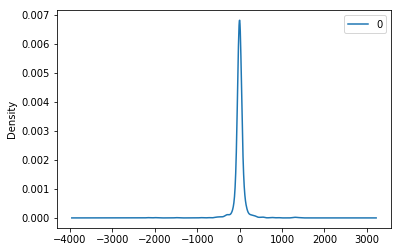

In [30]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
residuals.plot(kind='kde')
print(residuals.describe())

In [31]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(100).mean()
    rolstd = timeseries.rolling(100).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

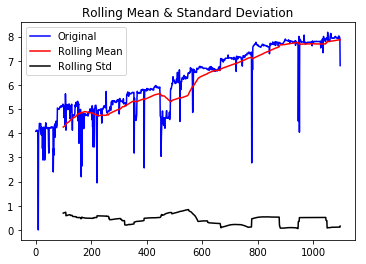

Results of Dickey-Fuller Test:
Test Statistic                   -1.658247
p-value                           0.452743
#Lags Used                       13.000000
Number of Observations Used    1085.000000
Critical Value (1%)              -3.436391
Critical Value (5%)              -2.864207
Critical Value (10%)             -2.568190
dtype: float64


In [32]:
test_stationarity(log_df)

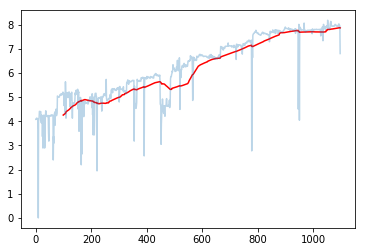

In [33]:
moving_avg = log_df.rolling(100).mean()
plt.plot(moving_avg, c = 'r')
plt.plot(log_df, alpha = .3)

In [34]:
ts_log_moving_avg_diff = log_df - moving_avg

In [35]:
ts_log_moving_avg_diff.dropna(inplace = True)

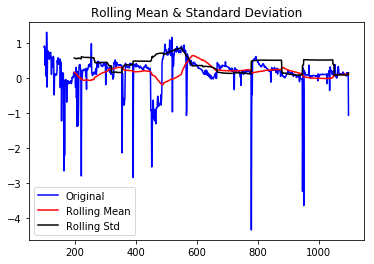

Results of Dickey-Fuller Test:
Test Statistic                -7.210055e+00
p-value                        2.247074e-10
#Lags Used                     3.000000e+00
Number of Observations Used    9.960000e+02
Critical Value (1%)           -3.436933e+00
Critical Value (5%)           -2.864446e+00
Critical Value (10%)          -2.568317e+00
dtype: float64


In [36]:
test_stationarity(ts_log_moving_avg_diff)